L'objectif de ce TIPE est d'étudier la possibilité de s'abstraire des perturbuation atmosphèrique lors de l'observation stellaire.

Afin de rentre ce TIPE le plus réaliste possible j'ai contacté des chercheurs de l'observatoire de Paris pour essayer d'obtenir un jeu de données "réel", perturbé par l'atmosphère pour mettre en oeuvre différentes techniques afin d'en améliorer l'observation. Après plusieurs échanges de mail, Eric Gendron, astrome à l'observatoire de Paris, m'a fourni plusieurs jeux de données concernant l'étoile double ε2 Lyr dans la constellation de la Lyre.

# Chargement des données

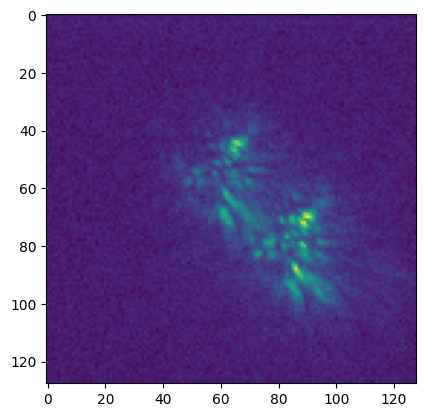

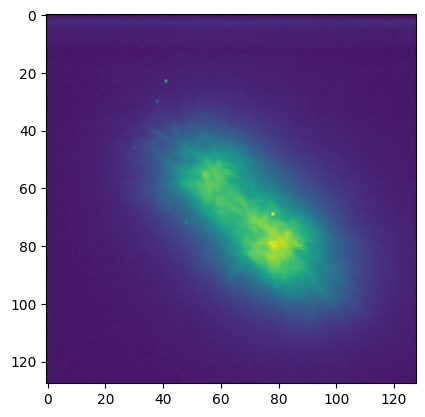

In [ ]:
import numpy as np
from astropy.io import fits
from skimage import io
import matplotlib.pyplot as plt

images = None
backgrounds = None

# charger l'ensemble des images (des étoiles et de référence) pause courte depuis les fichiers astro au format FITS
for i in range(0, 9):
  with fits.open("/content/eps_lyr_2_30ms_"+str(i)+".fits") as hdul:
    images = np.vstack((images, hdul[0].data)) if images is not None else hdul[0].data
  with fits.open("/content/eps_lyr_2_30ms_dark_"+str(i)+".fits") as hdul:
    backgrounds = np.vstack((backgrounds, hdul[0].data)) if backgrounds is not None else hdul[0].data

# un autre jeux de données avec pause de 90ms
"""
for i in range(0, 4):
  with fits.open("/content/eps_lyr_2_90ms_256_"+str(i)+".fits") as hdul:
    images = np.vstack((images, hdul[0].data)) if images is not None else hdul[0].data
  with fits.open("/content/eps_lyr_2_90ms_256_dark_"+str(i)+".fits") as hdul:
    backgrounds = np.vstack((backgrounds, hdul[0].data)) if backgrounds is not None else hdul[0].data
"""

# montrer une image des étoiles pause courte avec tavelures
plt.imshow(images[0])
plt.show()

# simuler une image pause longue pour voir à quoi ressemble un image des étoiles
# en pause normale (3 sec vs 30 ms) si l'on ne traite pas la perturbation atmosphérique
long_shot_image = np.divide(np.sum(images[:200], axis=0), 200)

plt.imshow(long_shot_image)

plt.show()

On s'appercoit que l'image est "flou". Typiquement en astronomie on va vouloir déterminer au moins 3 valeurs:
* le nombre d'étoiles observés (ici on peut supposer 2, mais ce n'est pas non plus totalement évident)
* la séparation angulaire des différentes étoiles
* la différence de magnitude entre les différences étoiles

Il parait évident qu'avec une tel photo il n'est possible d'effectuer aucune de ses mesures en raison du manque de netté de la photo.


On va mettre en oeuvre plusieurs techniques pour mesurer ces informations à partir du jeu de donné initial. Avant de commencer on va essayer de garder uniquement l'information importante dans les images en enlevant ce qui est "commun" à toute les images par exemple les pixels "chauds" (non opérant) sur le capteur.

# Pre-traitement pour enlever le fond et ne garder que l'information utile


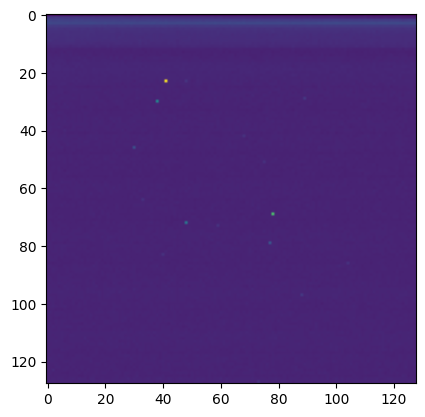

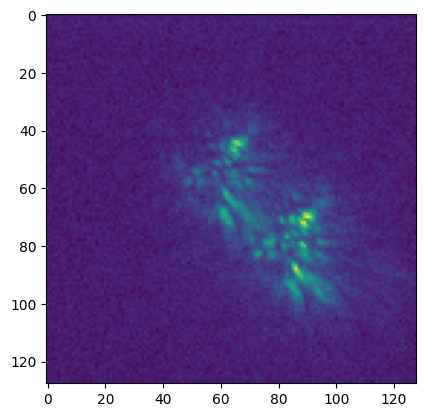

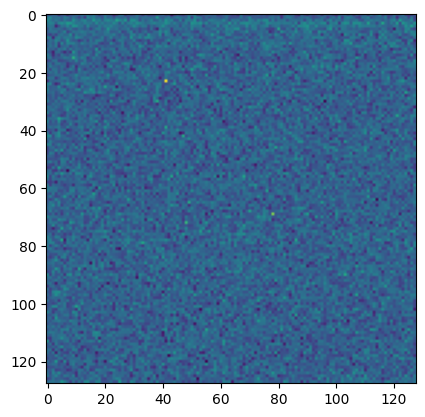

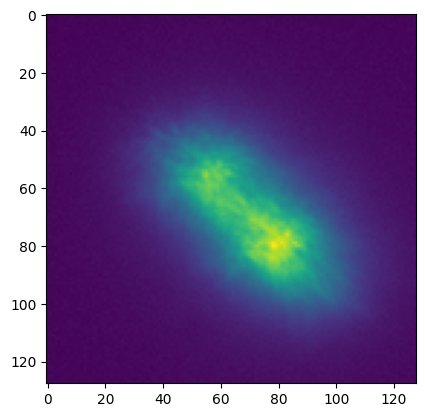

In [ ]:

average_background = np.mean(backgrounds, axis=0)

plt.imshow(average_background)
plt.show()

images_without_background = np.subtract(images, average_background)

plt.imshow(images[0])
plt.show()

references_without_background = np.subtract(backgrounds, average_background)

plt.imshow(backgrounds[0])
plt.show()

long_shot_image_without_background = long_shot_image - average_background

plt.imshow(long_shot_image_without_background)
plt.show()

Puisque nous avons l'impression d'avoir affaire à une image "floue" la première tentative est d'appliquer des opérations de convolution sur l'image qui a priori sont à même d'améliorer la netteté d'une image.

# Filtre de netteté


In [ ]:
from scipy.signal import convolve2d

io.imshow(long_shot_image_without_background)
io.show()

# cf https://fr.wikipedia.org/wiki/Noyau_(traitement_d%27image)
sharpen_image = convolve2d(long_shot_image_without_background,
                           np.array([[0., -1., 0.],[-1., 5., -1.],[0., -1., 0.]]))

plt.imshow(sharpen_image)
plt.show()

sharpen_image = (-1/256)*convolve2d(long_shot_image_without_background,
                                    np.array([[1., 4., 6., 4., 1.],[4., 16., 24., 16., 4.],
                                     [6., 24., -476., 24., 6.],[4., 16., 24., 16., 4.],[1., 4., 6., 4., 1.]]))

plt.imshow(sharpen_image)
plt.show()



On s'apercoit en pratique que l'image n'est pas forcément plus interprétable une fois ses convolutions appliquées. On peut à peine deviner qu'il y a 2 étoiles mais on ne peut certainement pas calculer leur distance angulaire ou leur différence d'intensité.

Si l'on s'en réfère à la littérature, cela est attendu, en effet, les perturbations atmosphériques ne produisent pas vraiment du "flou" au sens photographique du terme mais plutôt un ensemble d'imagine net mais perturbé par une fonction d'étalement du point.

In [ ]:
# fonction utilitaire pour transformer des dégrés décimaux en
# degrés, minutes, secondes utilisés en astronomie
def decdeg2dms(dd):
   is_positive = dd >= 0
   dd = abs(dd)
   minutes,seconds = divmod(dd*3600,60)
   degrees,minutes = divmod(minutes,60)
   degrees = degrees if is_positive else -degrees
   return (degrees,minutes,seconds)


In [ ]:
# pour detecter les étoiles j'utilise le package "sep", un autre package permet
# aussi de le faire: https://photutils.readthedocs.io/en/stable/detection.html
!pip install sep

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 17.7 MB/s eta 0:00:00


La première méthodes mise en oeuvr pour limiter l'effet de la pertubation est la méthode dite du "shift an add". Elle nécessite trois étapes:
1. dans le jeu de données, choisir le "meilleur" sous ensemble d'image
2. Ensuite pour chaque image:
  1. décaler l'image pour aligner ses étoiles sur celle des précédentes (si besoin)
  2. ajouter l'image au précédentes
3. faire la moyenne des images

Ainsi, en selectionnant les meilleurs images, en les alignement pour le mieux et en faisant la moyenne, on obtient une image final bien plus net.

# Shift and Add

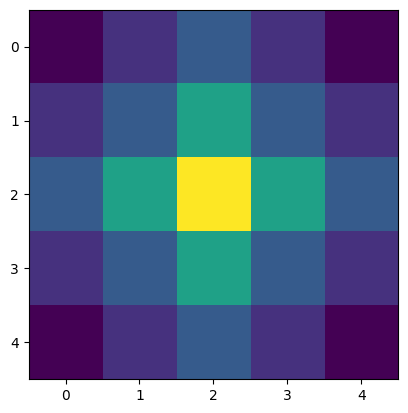

garder l'image  38
garder l'image  51
garder l'image  57
garder l'image  277
garder l'image  278
garder l'image  289
garder l'image  313
garder l'image  344
garder l'image  376
garder l'image  388
garder l'image  445
garder l'image  516
garder l'image  520
garder l'image  525
garder l'image  591
garder l'image  602
garder l'image  609
garder l'image  624
garder l'image  625
garder l'image  639
garder l'image  659
garder l'image  700
garder l'image  723
garder l'image  725
garder l'image  758
garder l'image  790
garder l'image  839
garder l'image  877
garder l'image  888
garder l'image  901
garder l'image  903
garder l'image  907
garder l'image  918
garder l'image  922
garder l'image  975
garder l'image  1000
garder l'image  1109
garder l'image  1110
garder l'image  1144
garder l'image  1148
garder l'image  1156
garder l'image  1168
garder l'image  1172
garder l'image  1233
garder l'image  1243
garder l'image  1340
garder l'image  1394
garder l'image  1395
garder l'image  1492
garder l'

<ipython-input-6-cb779652b11a>:99: FutureWarning: `imshow` is deprecated since version 0.25 and will be removed in version 0.27. Please use `matplotlib`, `napari`, etc. to visualize images.
  io.imshow(lucky_images_added / count)
/usr/local/lib/python3.11/dist-packages/skimage/io/_plugins/matplotlib_plugin.py:158: UserWarning: Float image out of standard range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)
<ipython-input-6-cb779652b11a>:100: FutureWarning: `show` is deprecated since version 0.25 and will be removed in version 0.27. Please use `matplotlib`, `napari`, etc. to visualize images.
  io.show()


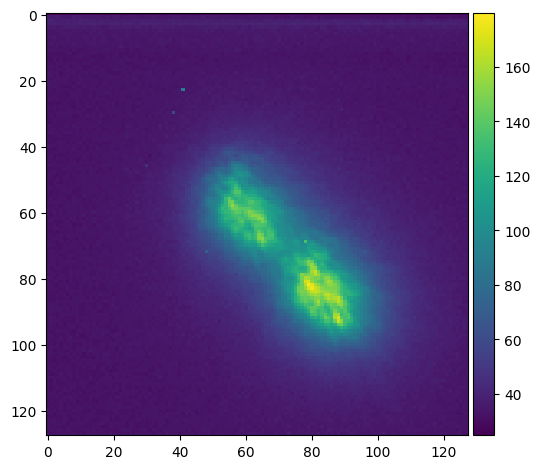

<ipython-input-6-cb779652b11a>:102: FutureWarning: `imshow` is deprecated since version 0.25 and will be removed in version 0.27. Please use `matplotlib`, `napari`, etc. to visualize images.
  io.imshow(lucky_images_shifted_and_added / count)
/usr/local/lib/python3.11/dist-packages/skimage/io/_plugins/matplotlib_plugin.py:158: UserWarning: Float image out of standard range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)
<ipython-input-6-cb779652b11a>:103: FutureWarning: `show` is deprecated since version 0.25 and will be removed in version 0.27. Please use `matplotlib`, `napari`, etc. to visualize images.
  io.show()


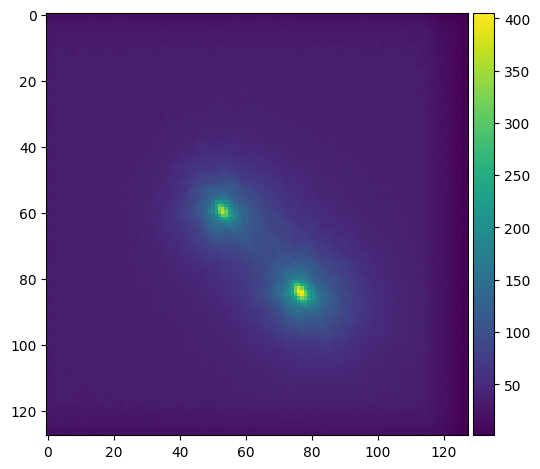

In [ ]:
import sep
from scipy.ndimage import shift

import matplotlib.pyplot as plt

# sep package ne marche pas avec des uint16
images = np.array(images, dtype='float64')

# sep va detecter à base d'algorithme de "Machine Learning"
# les étoiles ressemblants à celle qu'on lui donne en exemple.
# un noyau pour le filtre qui "ressemble" à un étoile
# https://sep.readthedocs.io/en/v1.1.x/filter.html
KERNEL = np.array([[1., 2., 3., 2., 1.],
                    [2., 3., 5., 3., 2.],
                    [3., 5., 8., 5., 3.],
                    [2., 3., 5., 3., 2.],
                    [1., 2., 3., 2., 1.]])

plt.imshow(KERNEL)
plt.show()

# cherche 2 objets (étoiles) dans l'image
def get_objects_from_data(data, globalrms):
    low_threshold = 0
    high_threshold = 500

    # à l'aide d'une recherche dichotomique trouve le bon threshold qui permet
    # de retourner le bon nombre d'étoiles à la marge prêt
    while True:
        cur_threshold = (low_threshold + high_threshold) / 2.0
        # https://sep.readthedocs.io/en/stable/tutorial.html#Object-detection
        result = sep.extract(data, cur_threshold, err=globalrms, filter_type="matched", filter_kernel=KERNEL)
        delta = 2 - len(result)
        if delta == 0:
            return result
        elif delta < 0:
            low_threshold = cur_threshold
        else:
            high_threshold = cur_threshold
        if high_threshold - low_threshold < 0.2:
            return None

# selectione l'image si la tavelure ne s'étend pas trop et si on trouve bien 2 étoiles
def select_image(data):
    # selection des images avec un bon constraste global
    contrast = (np.max(data) - np.min(data)) / (np.max(data) + np.min(data))
    #print("constrast", contrast)
    if contrast < 0.97:
      return False, None
    # https://sep.readthedocs.io/en/stable/tutorial.html#Background-subtraction
    # calcule le fond avec
    background = sep.Background(data)
    data = data - background
    # récupère 2 étoiles
    objects = get_objects_from_data(data, background.globalrms)
    # sélectione les images dont les étoiles ont un bon contraste
    if objects is not None:
      min = (objects["cflux"] - objects["cpeak"]) / (objects["npix"] - 1)
      contrasts = (objects["cpeak"] - min) / (objects["cpeak"] + min)
      #print(contrasts)
      if contrasts.max() < 0.2 or contrasts.min() < 0.15 or contrasts.mean() < 0.2:
        return False, None
    return objects is not None, objects


lucky_images_added = None
lucky_images_shifted_and_added = None

# décaler et ajouter les images selectionées
count = 0
for i, image in enumerate(images):
  select, objects = select_image(image)
  if select:
      count = count + 1
      print("garder l'image ", i)
      # add without shift
      lucky_images_added = np.add(lucky_images_added, image) if lucky_images_added is not None else image
      if lucky_images_shifted_and_added is None:
        # si on a pas encore commencé le processus, on prend la première image comme référence
        left_index = np.argmin(objects['x'])
        ref_x = objects['x'][left_index]
        ref_y = objects['y'][left_index]
        lucky_images_shifted_and_added = image
      else:
        # si on a qu'une étoile on ne sait pas top comment aligner, on utilise pas l'image
        if objects.size == 1:
          continue
        # on aligne toujours l'étoile la plus à gauche avec l'étoile réference de gauche
        left_index = np.argmin(objects['x'])
        shift_x = ref_x - objects['x'][left_index]
        shift_y = ref_y - objects['y'][left_index]
        image_shifted_vertically = shift(image, (shift_y, shift_x))
        lucky_images_shifted_and_added = np.add(lucky_images_shifted_and_added, image_shifted_vertically)

io.imshow(lucky_images_added / count)
io.show()

io.imshow(lucky_images_shifted_and_added / count)
io.show()



L'image finale est beaucoup plus net que l'original, les tavelures ne sont quasiment plus présentes. On va pouvoir essayer de calculer la distance angulaire entre les étoiles et leur différence de magnitude.

In [ ]:
# calcul de la séparation angulaire et de la différence magnitude à partir de la
# technique shift and add

import cv2
import math

# ces données correspondante au telescope et capteur photo qui ont été utilisés
# pour prendre en photo les étoiles
FOCAL_LENGTH = 21.75 # metres
PIXEL_SIZE = 7.4e-6 # metres

gray = np.array(255 * lucky_images_shifted_and_added / lucky_images_shifted_and_added.max(), dtype="uint8")

plt.imshow(gray)
plt.show()

ret, thresh = cv2.threshold(gray, 128, 255, 0)

plt.imshow(thresh)
plt.show()

contours, hierarchy = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

def compute_intensities(image, contours, index):
  mask = np.zeros_like(image)
  cv2.drawContours(mask, contours, index, color=255, thickness=-1)
  plt.imshow(mask)
  plt.show()
  points_to = np.where(mask == 255)
  intensities = gray[points_to[0], points_to[1]]
  return np.mean(intensities)

A = compute_intensities(gray, contours, 0)
B = compute_intensities(gray, contours, 1)

delta_mag = 2.5*math.log10(A/B)

print("différence de magnitude", delta_mag)

cv2.drawContours(gray, contours, -1, (255,255,255), -1)
plt.imshow(gray)
plt.show()

# calcul les barycentres des contours
star_0 = np.squeeze(contours[0].mean(axis=0))
star_1 = np.squeeze(contours[1].mean(axis=0))

nb_pixel = math.sqrt((star_0[0] - star_1[0])**2+(star_0[1] - star_1[1])**2)

print("séparation angulaire",
      decdeg2dms(math.degrees(2*math.atan(nb_pixel*PIXEL_SIZE/(2*FOCAL_LENGTH)))))

_, radius1 = cv2.minEnclosingCircle(contours[0])
_, radius2 = cv2.minEnclosingCircle(contours[1])

_, _, s1 = decdeg2dms(math.degrees(2*math.atan(radius1*PIXEL_SIZE/(2*FOCAL_LENGTH))))
_, _, s2 = decdeg2dms(math.degrees(2*math.atan(radius2*PIXEL_SIZE/(2*FOCAL_LENGTH))))

print("incertitude", math.sqrt(s1**2 + s2**2))

NameError: name 'lucky_images_shifted_and_added' is not defined

Avec cette technique nous obtenons donc une séparation angulaire de **2.42"** et une différence magnitude de **0,029**.
Il nous faut comparer cela aux résultats obtenus par la commauté scientifique pour l'étoile double ε2 Lyr.

Pour cela j'ai utilisé les source suivantes :
* le site des étoiles double de Nice (https://sidonie.oca.eu/Sidonie/Default.htm)
* la page Wikipedia des étoiles (https://fr.wikipedia.org/wiki/Epsilon_Lyrae)
* la base de donnée SIMBAD de l'université de Strasbourg (https://simbad.cds.unistra.fr/simbad/)


Les magnétitudes sont:
* doubles de Nices 4.9 et 5.2 => $\Delta mag=0.3$
* Wikipedia: 5.14 et 5.37 => $\Delta mag=0.25$
* Simbad:
   * filtre B 5.58 et 5.4 => $\Delta mag=0.18$
   * filtre V 5.35 et 5.23 => $\Delta mag=0.12$
   * filtre G 5.4 et 5.21 =>  $\Delta mag=0.19$

Explication des filtre/bandes fréquences: https://en.wikipedia.org/wiki/Photometric_system

Filtre utilisé sur le telescope (Source observatoire de Paris):
`il s'agit d'un filtre passe-bande allant de 580 à 720 (long d'onde centrale moyenne est donc de 650 nm)`

 donc on est sur du R, pas la donnée en R, le plus proche V = 5.35-5.23 = 0.12


In [ ]:
import pandas

def convert(value):
  return float(value)

# chargement et affichage des données issue du site de l'observatoire de Nice
data_frame = pandas.read_csv("doubles_de_nice.csv", sep= ";", encoding = "ISO-8859-1",
                             converters={'Sépar.': convert, 'Date': convert })
display(data_frame)

FileNotFoundError: [Errno 2] No such file or directory: 'doubles_de_nice.csv'

In [ ]:
data_frame[data_frame['Date'] > 1980].describe()

,Date,Sépar.
count,35.000000,35.000000
mean,1993.142206,2.372114
std,7.608623,0.085362
min,1980.547000,2.283000
25%,1986.207000,2.330000
50%,1992.885000,2.350000
75%,1999.614000,2.389000
max,2005.594000,2.742000


Si l'on se concentre sur les observations faites à partir de 1980, les valeurs trouvées sont en moyenne de **2.37"** alors que nous trouvons **2.42"** avec la méthode du shift and add. Nous sommes donc très  proche des observations faite par des scientifiques.

Mais peut-on faire mieux ?

Pour cela nous allons mettre en oeuvre une deuxième technique qui est celle d'interférométrie des tavelures.

# Interferométrie des tavelures (Labeyrie)

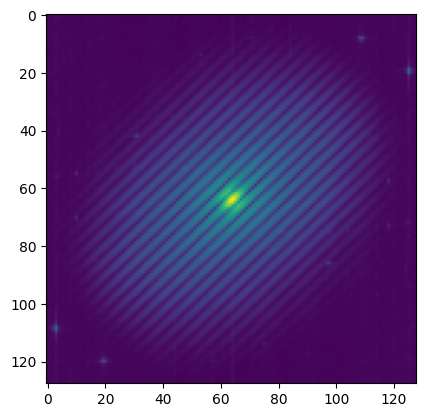

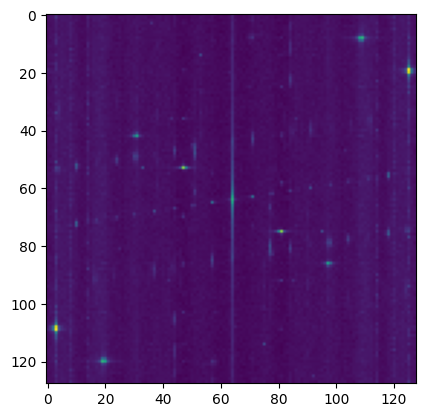

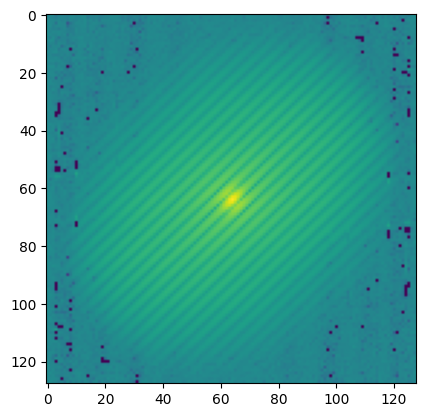

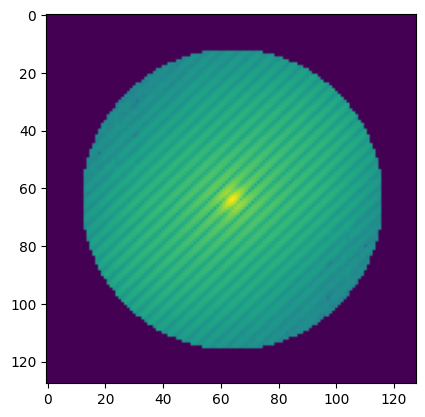

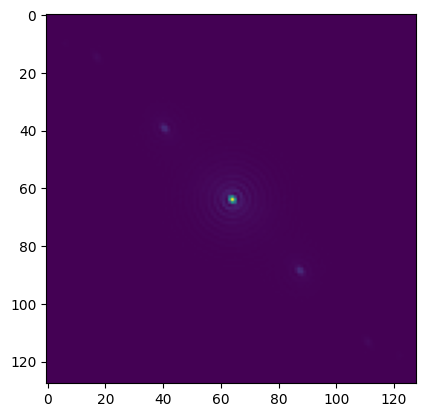

In [ ]:
def compute_autocorelation(images_without_background, references_without_background, show_image=True):
  # pour chaque image des étoiles ou reférence calculer sa densité spectrale de
  # puissance à partir de sa transformée de Fourier (carrée du module)
  images_psd = np.mean(np.square(np.abs(np.fft.fft2(images_without_background))), axis=0)
  if show_image:
    plt.imshow(np.log(np.fft.fftshift(images_psd)))
    plt.show()
  backgrounds_psd = np.mean(np.square(np.abs(np.fft.fft2(references_without_background))), axis=0)
  if show_image:
    plt.imshow(np.log(np.fft.fftshift(backgrounds_psd)))
    plt.show()

  # calculer la densité spectrale de puissance de l'objet original non perturbé
  objects_psd = images_psd - backgrounds_psd
  objects_psd[objects_psd < 1] = 1

  objects_psd_log = np.log(np.fft.fftshift(objects_psd))

  if show_image:
    plt.imshow(objects_psd_log)
    plt.show()

  # appliquer un filtre passe bas à l'aide d'un masque pour enlever le bruit résiduel
  image_size = objects_psd.shape[0]
  low_pass_mask = np.zeros(objects_psd.shape)
  xx, yy = np.meshgrid(np.arange(image_size), np.arange(image_size))
  cxy = int(image_size / 2)
  xx = xx - cxy
  yy = yy - cxy
  rr = np.sqrt(np.square(xx) + np.square(yy))
  low_pass_mask[rr < 52] = 1
  objects_low_pass = objects_psd_log * low_pass_mask

  if show_image:
    plt.imshow(objects_low_pass)
    plt.show()

  # en pratique la densité spectrale de puissance est un cosinus
  # pour peut qu'on ne change pas sa période on peut "jouer"
  # avec la fonction pour créer un meilleur constrate afin d'obtenir
  # une autocorrelation plus claire
  twicked_psd = np.power(np.exp(objects_low_pass).astype(np.complex64), 0.3)

  # la transformée de Fourier inverse du carré du module la transformée de Fourier du signal
  # donne l'auto-correleration du signal
  autocorelation = np.fft.ifft2(twicked_psd)
  # on décale pour avoir la valeur 0 au centre
  autocorelation = np.abs(np.fft.ifftshift(autocorelation))

  return autocorelation, objects_low_pass

autocorelation, objects_low_pass = compute_autocorelation(images_without_background, references_without_background)
plt.imshow(autocorelation)
plt.show()

Deux étoiles "idéales" modélisées par la "fonction" de Dirac $\delta$, d'intensités $A$ et $B$ et séparées par un écart angulaire $s$ produisent une intensité incidente $I$ telle que:
$I(x) = A\delta(x-\dfrac{s}{2}) + B\delta(x+\dfrac{s}{2})$

L'autocorrelation c'est à dire la convolution de la fonction $I$ par elle même :
1. permet de determiner la distance entre les 2 étoiles, en effet:

$C_{I}(\rho)=I(\rho) \circledast I(-\rho)=\int I(x)I(x+\rho)dx$
$=\int (A\delta(x-\dfrac{s}{2}) + B\delta(x+\dfrac{s}{2}))(A\delta(x + \rho-\dfrac{s}{2}) + B\delta(x+\rho+\dfrac{s}{2}))dx$
$=A^2\delta(\rho)+B^2\delta(\rho)+AB\delta(\rho+s)+AB\delta(\rho-s)$

Donc $\forall \rho \notin \{-s, 0, s\}$
$C_{I}(\rho) = 0$
$C_{I}(0)=A^2+B^2$
$C_{I}({s})=AB,C_{I}({-s})=AB$

Donc la séparation angulaire est la distance entre la valeur centrale et les valeurs sur les côtés de l'autocorrelation

2. cette autocorrelation a une transformée de Fourier égale au carré du module de de la transformée de Fourier de $I$ et donc peut se calculer aisément à partir de celle-ci:

en effet:
$\mathcal{F(C_{I})}=\mathcal{F(\int I(r)I(r+\rho)dr)}$
$=\int (\int I(r)I(r+\rho)dr)e^{-i2\pi vx}dx$
$=\int \int I(r)I(r+\rho)e^{-i2\pi vx}dxdr$
$=\int I(r)(\int I(r+\rho)e^{-i2\pi vx}dx)dr$
$=\int I(r)\mathcal{F(I(r+\rho))}dr$
$=\int I(r)\mathcal{F(I(u))}e^{i2\pi ur}dr$ // translation temporelle de la TF
$=\mathcal{F(I(u))}\int I(r)^{i2\pi ur}dr$
$=\mathcal{F(I(u))}\mathcal{F(I(-u))}$
$=|\mathcal{F(I(u))}|^2$


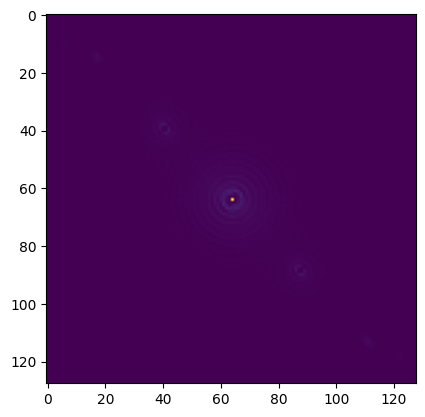

séparation angulaire (0.0, 0.0, 2.3824185319822644)
incertitude 0.07255639858447019


In [ ]:
# calcul de la séparation angulaire à partir de l'interferométrie des tavelures
import cv2
import math

def compute_angular_separation(autocorelation, show_image=True):
  gray = np.array(255 * autocorelation / autocorelation.max(), dtype="uint8")
  # OpenCV fait une erreur si on n'appelle pas cette fonction
  gray = np.ascontiguousarray(gray, dtype=np.uint8)
  ret, thresh = cv2.threshold(gray, 20, 255, 0)
  contours, hierarchy = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
  cv2.drawContours(gray, contours, -1, (0,255,0), 0)
  if show_image:
    plt.imshow(gray)
    plt.show()

  # calcul les barycentres des contours
  star_0 = np.squeeze(contours[0].mean(axis=0))
  star_1 = np.squeeze(contours[1].mean(axis=0))

  # distance en pixels entre la valeur centrale et celle du bord
  nb_pixel = math.sqrt((star_0[0] - star_1[0])**2+(star_0[1] - star_1[1])**2)

  return nb_pixel

# distance angulaire en prenant en compte les caractéristique du téléscope
nb_pixel = compute_angular_separation(autocorelation)
print("séparation angulaire", decdeg2dms(math.degrees(2*math.atan(nb_pixel*PIXEL_SIZE/(2*FOCAL_LENGTH)))))

# après échange avec Eric Gendron, multiples mesures sur des sous ensemble
# pour calculer l'incertitude

nb_pixels = np.empty(len(images_without_background) // 100)
for i in range(nb_pixels.size):
  autocorelation, _ = compute_autocorelation(images_without_background[i*100:(i+1)*100],
                                             references_without_background[i*100:(i+1)*100], False)
  nb_pixels[i] = compute_angular_separation(autocorelation, False)

_, _, incertitude = decdeg2dms(math.degrees(2*math.atan(np.std(nb_pixels)*PIXEL_SIZE/(2*FOCAL_LENGTH))))
print("incertitude", incertitude)


Maintenant que la distance angulaire est calculée, comment calculer la différence magnitude entre les étoiles ?

En repartant de:
$I(x) = A\delta(x-\dfrac{s}{2}) + B\delta(x+\dfrac{s}{2})$

$\mathcal{F(I)}=\int I(x)e^{-i2\pi vx}dx$
$ = \int A\delta(x-\dfrac{s}{2})e^{-i2\pi vx} + \int B\delta(x+\dfrac{s}{2})e^{-i2\pi vx}dx$
$= Ae^{-i\pi vs} + Be^{i\pi vs}$
$= A(cos(\pi vs) - isin(\pi vs)) + B(cos(\pi vs) + isin(\pi vs))$
$= (A+B) \cos (\pi vs)+i (B-A) \sin (\pi vs)$

Le module au carrée de la tranformée de Fourier de cette intensité est donc :

$|\mathcal{F(I)}|^{2}$
$=A^2cos^2(\pi vs) +B^2cos^2(\pi vs) +2ABcos^2(\pi vs) +
A^2sin^2(\pi vs) + B^2sin^2(\pi vs) - 2ABsin^2(\pi vs)$
$=A^2+B^2+2ABcos(2\pi vs)$

$4AB$ est l'amplitude du signal ($a$) et $A^2+B^2$ sa valeur moyenne ($m$).

Si l'on mesure $r=\dfrac{m}{a}$ sur le tracé du carré du module de la transformée de Fourier alors $r=\dfrac{A^2+B^2}{4AB}$

donc $A^2+B^2-4ABr=0$

donc $\dfrac{A}{B}+\dfrac{B}{A}-4r=0$

donc $(\dfrac{A}{B})^{2}-4r(\dfrac{A}{B})=-1$

donc $(\dfrac{A}{B})^{2}-4r(\dfrac{A}{B})+4r^{2}=4r^{2}-1$

donc $(\dfrac{A}{B}-2r)^2 = 4r^{2}-1$

donc $A/B=2r + \sqrt{4r^{2}-1}$

d'autre part $\Delta mag= 2.5\log{A}-2.5\log{B}=2.5\log{\dfrac{A}{B}}$

mesurer l'amplitude et la moyenne nous permet donc de determiner la différence de magnitude.

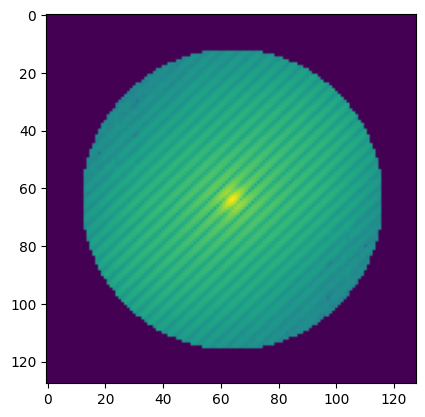

3804


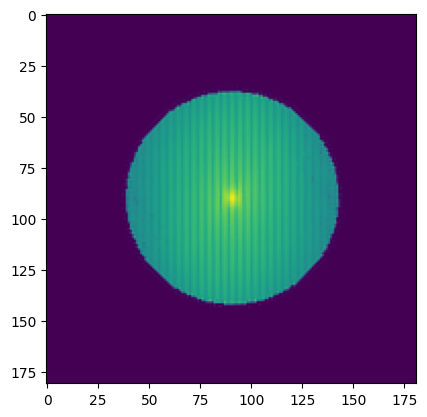

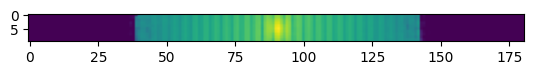

différence de magnitude 0.2728343362834558
incertitude 0.051839472419028934
(np.float64(11.600451016674887), np.float64(22.74637640160252))
0.3453772432866601


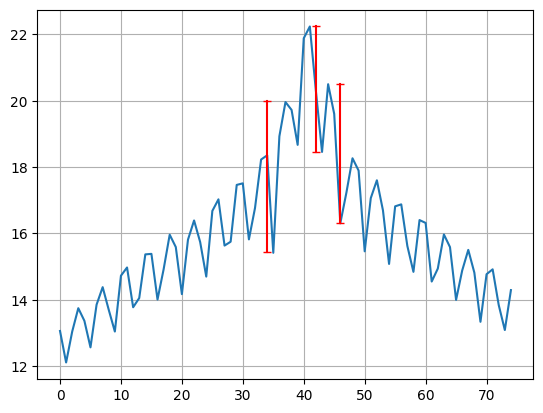

In [ ]:
# calcul de la différence de magnitude à partir de l'interférométrie des tavelures

from scipy.ndimage import rotate

log_psd = objects_low_pass
plt.imshow(log_psd)
plt.show()

# on tourne l'image pour obtenir une image alignée
inter_psd = rotate(log_psd, 46.5, cval=0, order=5)

print((inter_psd < 0).sum())

inter_psd[inter_psd < 0] = 0
plt.imshow(inter_psd)
plt.show()

# on prend les lignes significatives
center = inter_psd[85:95]
# pour les photos 90ms
# center = inter_psd[175:185]

plt.imshow(center)
plt.show()

# on prend la médiane des valeurs
median = np.median(center, axis=0);

# on écarte les bords sans oscillation
median = median[50:125]
# pour les photos 90ms
# median = median[140:240]

fig, ax = plt.subplots()

# on trace la courbe des valeures médianes
ax.plot(median)

# sur cette courbe on répère la main les min et max des oscillations centrales
low_log = [15.45, 18.45, 16.3]
high_log = [20, 22.25, 20.5]

# on en déduit la différence de magnitude
# pour cela on inverse le log
low = np.exp(low_log)
high = np.exp(high_log)
m = (low+high)/2
a = (high-low)
r = m / a
AdivB = 2*r + np.sqrt(4*r**2-1)

delta_mag = 2.5*np.log10(AdivB)

print("différence de magnitude", delta_mag.mean())

print("incertitude", np.sqrt((((delta_mag - delta_mag.mean())**2).sum()/2)))

# on trace sur la courbe les min et max d'une oscillation
ylim = ax.get_ylim()
extend = ylim[1]-ylim[0]

print(ylim)
print((low_log[0]-ylim[0])/extend)
ax.axvline(x = 34, ymin=(low_log[0]-ylim[0])/extend,
           ymax = (high_log[0]-ylim[0])/extend, color = 'r', marker = '_')
ax.axvline(x = 42, ymin=(low_log[1]-ylim[0])/extend,
           ymax = (high_log[1]-ylim[0])/extend, color = 'r', marker = '_')
ax.axvline(x = 46, ymin=(low_log[2]-ylim[0])/extend,
           ymax = (high_log[2]-ylim[0])/extend, color = 'r', marker = '_')


ax.grid()

plt.show()

Avec l'interformetrie des taveleurs nous obtenons **2.38"** de séparation angulaire (contre **2.37"** en moyenne depuis 1980 sur le site de l'observtoire de Nice) et **0.27** de différence de magnitude.  